In [355]:
# Operating System
import os

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

# detect file encoding
import chardet

from sqlalchemy import create_engine

# HTTP requests
import requests

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.pipeline import  Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin, BaseEstimator

import category_encoders as ce
from sklearn.preprocessing import KBinsDiscretizer, Binarizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.impute import SimpleImputer

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix


#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import binom_test

# Strings
import re

---

# Import submission set

In [2]:
dir_path = os.path.join('data', 'transformed_data', 'data_test', 'test')
#print(dir_path)

df_submission = None
df_aux = None
file_counter = 0

for filename in os.listdir(dir_path):
    
    if filename.endswith(".xlsx"): 
        #print(os.path.join(dir_path, filename))
                
        df_list = []
        # Read two sheets in each file
        for sheet in ['sheet_1', 'sheet_2']:            
            try:
                df_aux = pd.read_excel(os.path.join(dir_path, filename), sheet_name=sheet, index_col=0).sort_index()
            except:
                print(os.path.join(dir_path, filename))
                print("{} reading error!".format(sheet))
                break
            
            df_list.append(df_aux.copy())
            del df_aux
            
        # Confirm both sheets had the same elements
        if df_list[0].index.equals(df_list[1].index) == False:
            print("df_list[0].index doesn't match df_list[1].index")
            break
        
        # Merge sheets
        df_aux_merged = pd.concat(df_list, axis='columns', sort=False)
        file_counter += 1
        del df_list
       
    
    
    if df_submission is None:        
        # Se for o 1º ficheiro a ser lido cria a dataframe        
        df_submission = df_aux_merged.copy()
        del df_aux_merged        
    else:
        
        # Confirmar se tem as mesmas colunas
        if df_submission.columns.equals(df_aux_merged.columns):
            df_submission = df_submission.append(df_aux_merged)
            del df_aux_merged
            
        else:
            print(os.path.join(dir_path, filename))
            print("File columns doesn't match with existing df_submission.")
            break


df_submission = df_submission.sort_index()
# Confirm that it is equal to the sample submission ids
try: 
    df_aux = pd.read_csv(os.path.join('data', 'sample_submission.csv'), index_col=0).sort_index()
except:
    print("Unable to read '{}' file".format(os.path.join('data', 'sample_submission.csv')))
                         
if df_submission.index.equals(df_aux.index) == False:
    print("ERROR!!! df_submission ids are not equal to 'sample_submission.csv' ids")
                        
print("{} files read".format(file_counter))

100 files read


In [3]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93310 entries, 00007c55a9a7591b98a76d79216c9112 to ffff9979c9699b51cb7cda98e5bf84c2
Data columns (total 30 columns):
orderportalid             93310 non-null int64
orderdate_gmt             93310 non-null object
designer                  93310 non-null int64
style                     93310 non-null int64
shipper                   93310 non-null int64
shiptypeid                93310 non-null int64
userid                    93202 non-null float64
isvip                     93202 non-null object
country                   93310 non-null int64
region                    93310 non-null int64
ddprate                   93310 non-null float64
countrycode               93310 non-null int64
hasusedwishlist           93202 non-null object
isreseller                93202 non-null object
hasitemsonbag             93202 non-null object
tierafterorder            85809 non-null object
tierbeforeorder           57397 non-null object
isusingmultipledevices    93

In [17]:
type(df_submission.dtypes)

pandas.core.series.Series

---

---

# Querying SQL database - target

In [201]:
host = 'data-wrangling-batch3.cl9uj9cucww7.eu-west-1.rds.amazonaws.com'
port = 5432
database = 'datawrangling'
user = 'ldsa_student'
password = 'JGIYc6jD' # replace with the datab ase password!

In [205]:
# Db settings - PostgreSQL
username = 'ldsa_student'
password = 'JGIYc6jD'  # the password is not XXX by the way
host_name = 'data-wrangling-batch3.cl9uj9cucww7.eu-west-1.rds.amazonaws.com'
port = 5432
db_name = 'datawrangling'
schema = 'hackathon_students'

conn_str = 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host_name, port, db_name)
conn_args = {'options': '-csearch_path={}'.format(schema)}

In [209]:
engine = create_engine(conn_str, connect_args=conn_args)

In [210]:
query = 'SELECT * FROM hackathon_students.targets;'
targets = pd.read_sql_query(query, engine)

In [272]:
df_target = targets.set_index('id').sort_index()

In [505]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543341 entries, 00003e3b9e5336685200ae85d21b4f5e to fffffe98d0963d27015c198262d97221
Data columns (total 1 columns):
returned    543341 non-null int64
dtypes: int64(1)
memory usage: 28.3+ MB


---

---

# Import data source 1  
### ['tierafterorder', 'orderportalid', 'size', 'orderdate_gmt', 'hasusedwishlist']

In [215]:
file_path = os.path.join('data', 'datasource1.csv')

with open(file_path, 'rb') as f:
    read_nbytes = 100000
    encoding_dict = chardet.detect(f.read(read_nbytes))

encoding_dict

{'encoding': 'windows-1251',
 'confidence': 0.5730969056434915,
 'language': 'Bulgarian'}

### Read the file

In [289]:
df1 = pd.read_csv(os.path.join('data', 'datasource1.csv'), encoding=file_encod, index_col=0).sort_index()

In [290]:
df1 = df1.loc[:,['tierafterorder', 'orderportalid', 'size', 'orderdate_gmt', 'hasusedwishlist']]

In [291]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543341 entries, 00003e3b9e5336685200ae85d21b4f5e to fffffe98d0963d27015c198262d97221
Data columns (total 5 columns):
tierafterorder     511877 non-null object
orderportalid      543341 non-null object
size               543341 non-null object
orderdate_gmt      543341 non-null object
hasusedwishlist    542659 non-null object
dtypes: object(5)
memory usage: 24.9+ MB


# Import data source 2  
### ['shipper', 'productid', 'isreseller', 'issale', 'category_1stlevel']

### Read the file

In [235]:
df2 = pd.read_json(os.path.join('data', 'datasource2.json'), orient='split').sort_index()

In [236]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543341 entries, 00003e3b9e5336685200ae85d21b4f5e to fffffe98d0963d27015c198262d97221
Data columns (total 5 columns):
shipper              543341 non-null object
productid            543341 non-null object
isreseller           542659 non-null object
issale               543341 non-null object
category_1stlevel    542729 non-null object
dtypes: object(5)
memory usage: 24.9+ MB


# Import data source 3  
### ['tierbeforeorder' 'ddprate' 'platform' 'style' 'region']

### Read the file

In [238]:
df3 = pd.read_csv(os.path.join('data', 'datasource3.csv'), sep='|', index_col=0).sort_index()

In [239]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543341 entries, 00003e3b9e5336685200ae85d21b4f5e to fffffe98d0963d27015c198262d97221
Data columns (total 5 columns):
tierbeforeorder    369989 non-null object
ddprate            543341 non-null object
platform           455463 non-null object
style              543341 non-null object
region             543341 non-null object
dtypes: object(5)
memory usage: 24.9+ MB


In [240]:
print(df3.columns.values)

['tierbeforeorder' 'ddprate' 'platform' 'style' 'region']


# Import data source 4
### ['isusingmultipledevices', 'freereturn', 'userid']

### Read the file

In [241]:
df4 = pd.read_html(os.path.join('data', 'datasource4.html'), attrs = {'class': 'dataframe'})

In [244]:
df4 = df4[0]

In [245]:
df4.columns = df4.columns.droplevel(level=0)

In [247]:
df4 = df4.set_index('id').sort_index()

In [249]:
df4.columns =  ['isusingmultipledevices', 'freereturn', 'userid']

In [250]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543341 entries, 00003e3b9e5336685200ae85d21b4f5e to fffffe98d0963d27015c198262d97221
Data columns (total 3 columns):
isusingmultipledevices    542659 non-null object
freereturn                543341 non-null object
userid                    542659 non-null object
dtypes: object(3)
memory usage: 16.6+ MB


# Import data source 5  
### ['isvip', 'brand', 'promocode', 'designer']

### Read the file

In [254]:
df5 = pd.read_json(os.path.join('data', 'datasource5.csv'), orient='columns').sort_index()

In [255]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543341 entries, 00003e3b9e5336685200ae85d21b4f5e to fffffe98d0963d27015c198262d97221
Data columns (total 4 columns):
isvip        542659 non-null object
brand        543341 non-null object
promocode    543341 non-null object
designer     543341 non-null object
dtypes: object(4)
memory usage: 20.7+ MB


In [257]:
df5.columns.values

array(['isvip', 'brand', 'promocode', 'designer'], dtype=object)

# Import data source 6

# Import data source 7  
### ['countrycode','countryoforigin','userfraudstatus']

### Read the file

In [263]:
df7 = pd.read_csv(os.path.join('data', 'datasource7.csv'), index_col=0).sort_index()

In [268]:
df7 = df7.loc[:,['countrycode','countryoforigin','userfraudstatus']]

In [269]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543342 entries, 00003e3b9e5336685200ae85d21b4f5e to squirrel
Data columns (total 3 columns):
countrycode        543342 non-null object
countryoforigin    543342 non-null object
userfraudstatus    543342 non-null object
dtypes: object(3)
memory usage: 36.6+ MB


---

---

---

# Join target and local files databases

In [293]:
df_total = (df_target.join(df1)
                     .join(df2)
                     .join(df3)
                     .join(df4)
                     .join(df5)
                     .join(df7))

In [294]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 543341 entries, 00003e3b9e5336685200ae85d21b4f5e to fffffe98d0963d27015c198262d97221
Data columns (total 26 columns):
returned                  543341 non-null int64
tierafterorder            511877 non-null object
orderportalid             543341 non-null object
size                      543341 non-null object
orderdate_gmt             543341 non-null object
hasusedwishlist           542659 non-null object
shipper                   543341 non-null object
productid                 543341 non-null object
isreseller                542659 non-null object
issale                    543341 non-null object
category_1stlevel         542729 non-null object
tierbeforeorder           369989 non-null object
ddprate                   543341 non-null object
platform                  455463 non-null object
style                     543341 non-null object
region                    543341 non-null object
isusingmultipledevices    542659 non-null object
freer

---

# Data preprocessing

#### Check missing columns

In [295]:
cols_missing = [col for col in df_submission.columns if col not in df_total.columns]
cols_missing

['shiptypeid', 'country', 'hasitemsonbag', 'ddpsubcategory', 'storeid']

#### Create a copy of the complete dataframa

In [422]:
df_clean = df_total.drop(columns='returned').copy()

#### Drop observations with data missing from API and Website

In [423]:
df_clean = df_clean.mask(lambda x: x=="API").mask(lambda x: x=="WEBSITE").dropna(how='all')

#### Duplicates

Even if there are duplicates, we will leave them all in the dataframe because the ids are different. 

In [424]:
df_clean[df_clean.duplicated()].sort_values('orderdate_gmt').head(10)

,tierafterorder,orderportalid,size,orderdate_gmt,hasusedwishlist,shipper,productid,isreseller,issale,category_1stlevel,...,isusingmultipledevices,freereturn,userid,isvip,brand,promocode,designer,countrycode,countryoforigin,userfraudstatus
id,,,,,,,,,,,,,,,,,,,,,
c410003ef13d451727aeff9082c29a5c,T3,295,26,2018-01-01 02:19:39.903000+00:00,No,4,429,No,No,Shoes,...,No,1,285,Not VIP,92,1,425,14,1,3
35051070e572e47d2c26c241ab88307f,T3,295,26,2018-01-01 02:19:39.903000+00:00,No,4,429,No,No,Shoes,...,No,1,285,Not VIP,92,1,425,14,1,3
2f55707d4193dc27118a0f19a1985716,T3,295,26,2018-01-01 02:19:39.903000+00:00,No,4,429,No,No,Shoes,...,No,1,285,Not VIP,92,1,425,14,1,3
559cb990c9dffd8675f6bc2186971dc2,T3,295,26,2018-01-01 02:19:39.903000+00:00,No,4,429,No,No,Shoes,...,No,1,285,Not VIP,92,1,425,14,1,3
e3251075554389fe91d17a794861d47b,T3,676,14,2018-01-01 05:28:05.813000+00:00,Yes,2,1055,No,No,Clothing,...,No,1,650,Not VIP,46,1,1035,3,21,3
fa1e9c965314ccd7810fb5ea838303e5,T1,808,150,2018-01-01 06:40:08.226000+00:00,Yes,4,1257,Yes,No,Clothing,...,Yes,1,775,Not VIP,46,1,56,45,21,3
621fbd17da27241c58015eabe4164a52,T4,1932,1,2018-01-01 13:47:19.400000+00:00,No,5,319,No,No,Accessories,...,No,1,1851,Not VIP,87,1,317,4,2,4
31ca0ca71184bbdb3de7b20a51e88e90,T4,1932,1,2018-01-01 13:47:19.400000+00:00,No,5,319,No,No,Accessories,...,No,1,1851,Not VIP,87,1,317,4,2,4
5d2c2cee8ab0b9a36bd1ed7196bd6c4a,VIP,1951,324,2018-01-01 13:52:23.023000+00:00,Yes,5,1298,Yes,Yes,Shoes,...,Yes,1,1869,Not VIP,99,1,1269,16,23,6


#### Convert dtypes to match those in df_submission

In [425]:
#cols_to_convert = [col for col in df_submission.select_dtypes(include=np.number).columns]

df_clean = df_clean.astype(df_submission.dtypes[df_clean.columns])


#### Drop id columns

In [426]:
df_clean = df_clean.drop(columns=['userid', 'orderportalid', 'designer', 'style'])

---

# Train-Test split

In [427]:
X_train, X_test, y_train, y_test = train_test_split(df_clean, 
                                                    df_target.loc[df_clean.index,:], 
                                                    test_size=0.3, 
                                                    random_state=42)

---

# Classifier workflow

In [429]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.key]


In [430]:
# select_pipe = Pipeline([('ordinalencoder', ce.ordinal.OrdinalEncoder()),
#                         ('handle_unknown_imputer', SimpleImputer(missing_values=-1, strategy='most_frequent')),
#                         ('handle_missing_imputer1', SimpleImputer(missing_values=-2, strategy='most_frequent')),
#                         ('k_best', SelectKBest(chi2, k='all'))
#                        ])

In [431]:
# encode_pipe = Pipeline([('handle_unknown_imputer0', SimpleImputer(strategy='most_frequent')),
#                         ('ordinalencoder', ce.ordinal.OrdinalEncoder())
#                         #('handle_unknown_imputer1', SimpleImputer(missing_values=-1, strategy='most_frequent')),
#                         #('handle_missing_imputer2', SimpleImputer(missing_values=-2, strategy='most_frequent'))
#                        ])

In [473]:
num_pipe = Pipeline([('selector', Selector(X_train.select_dtypes(include=np.number).columns)) #, ('handle_nan_imputer', SimpleImputer(strategy='most_frequent'))
                    ])

text_pipe = Pipeline([('selector', Selector(X_train.select_dtypes(include=object).columns)),
                      ('ordinalencoder', ce.ordinal.OrdinalEncoder())
                     ])

# Feature Union allow use to use multiple distinct features in our classifier
feats = FeatureUnion([('text', text_pipe), 
                      ('numerical', num_pipe)])

best_k_pipe = Pipeline([('features',feats), 
                        ('k_best', SelectKBest(chi2, k=15))
                       ])

clf_pipe = Pipeline([('best_k_pipe', best_k_pipe), 
                     ('classifier', RandomForestClassifier(random_state = 42))
                    ])


In [474]:
clf_pipe.fit(X_train, y_train)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
     steps=[('best_k_pipe', Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('selector', Selector(key=Index(['tierafterorder', 'orderdate_gmt', 'hasusedwishlist', 'isreseller',
       'issale', 'category_1stlevel...mators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [475]:
decision_thr = 0.5
y_prob = clf_pipe.predict_proba(X_test)[:,1]
y_pred = y_prob > decision_thr
y_true = y_test

In [481]:
# best_k_pipe.fit_transform(X_train, y_train)

In [482]:
#best_k_pipe.steps[1][1].scores_

In [483]:
#plt.bar(X_train.columns, np.log10(best_k_pipe.steps[1][1].scores_))

# Classifier assessment

In [476]:
precision = precision_score(y_true, y_pred)
precision

0.8952867425121894

In [477]:
recall = recall_score(y_true, y_pred)
recall

0.3843317053722715

In [478]:
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
AUROC = roc_auc_score(y_test, y_prob)*100
AUROC

75.98851354493353

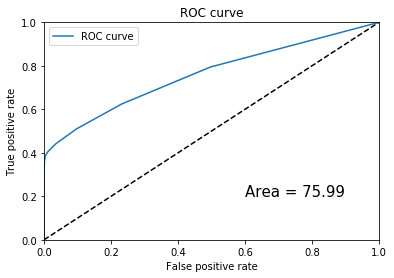

In [479]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.text(0.6, 0.2, "Area = {}".format(round(AUROC,2)), dict(size=15))

plt.legend(loc='best')
plt.show()

---

---

---

# Build submission file

In [494]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93310 entries, 00007c55a9a7591b98a76d79216c9112 to ffff9979c9699b51cb7cda98e5bf84c2
Data columns (total 30 columns):
orderportalid             93310 non-null int64
orderdate_gmt             93310 non-null object
designer                  93310 non-null int64
style                     93310 non-null int64
shipper                   93310 non-null int64
shiptypeid                93310 non-null int64
userid                    93202 non-null float64
isvip                     93202 non-null object
country                   93310 non-null int64
region                    93310 non-null int64
ddprate                   93310 non-null float64
countrycode               93310 non-null int64
hasusedwishlist           93202 non-null object
isreseller                93202 non-null object
hasitemsonbag             93202 non-null object
tierafterorder            85809 non-null object
tierbeforeorder           57397 non-null object
isusingmultipledevices    93

In [495]:
y_prob_submission = clf_pipe.predict_proba(df_submission)[:,-1]

In [501]:
pd.DataFrame({'id': df_submission.index, 'returned': y_prob_submission}).to_csv("submission_file.csv", index=False)

# Prepare presentation

In [553]:
df_train = X_train.join(y_train)

In [554]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345338 entries, 4442f6b0d386f06448947b8d0e1f169d to 3f17ecf97c107a3ec1b63295fa3a1bb9
Data columns (total 22 columns):
tierafterorder            323394 non-null object
size                      345338 non-null int64
orderdate_gmt             345338 non-null object
hasusedwishlist           344865 non-null object
shipper                   345338 non-null int64
productid                 345338 non-null int64
isreseller                344865 non-null object
issale                    345338 non-null object
category_1stlevel         344918 non-null object
tierbeforeorder           224064 non-null object
ddprate                   345338 non-null float64
platform                  284004 non-null object
region                    345338 non-null int64
isusingmultipledevices    344865 non-null object
freereturn                345338 non-null int64
isvip                     344865 non-null object
brand                     345338 non-null int64
promocode

In [584]:
df_train.corr()['returned'].sort_values()

shipper           -0.046763
region            -0.030314
countrycode       -0.029145
ddprate           -0.001874
countryoforigin   -0.001009
userfraudstatus    0.000462
size               0.011912
brand              0.023631
promocode          0.025848
freereturn         0.026065
productid          0.135410
returned           1.000000
Name: returned, dtype: float64

### Feature: Test different features

In [597]:
feature = "region"

In [598]:
df_train[feature].nunique()

7

In [599]:
df_train[feature].value_counts()

3    139763
4     94436
1     88400
2     21059
5      1171
6       499
7        10
Name: region, dtype: int64

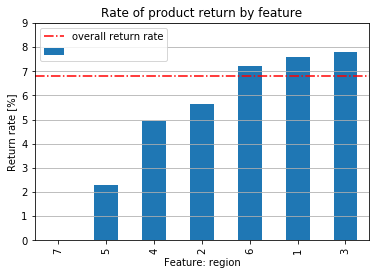

In [600]:
df_train.groupby(feature).returned.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

plt.axhline(y=df_train.returned.mean()*100, color='r', linestyle='-.', label='overall return rate')

plt.title('Rate of product return by feature')
plt.xlabel("Feature: {}".format(feature))
plt.ylabel("Return rate [%]")

plt.ylim(0,9)

plt.grid(axis='y')
plt.legend(loc="upper left", labels=['overall return rate','']);


### Feature: platform

In [589]:
feature = "platform"

In [590]:
df_train[feature].nunique()

2

In [591]:
df_train[feature].value_counts()

web    199976
app     84028
Name: platform, dtype: int64

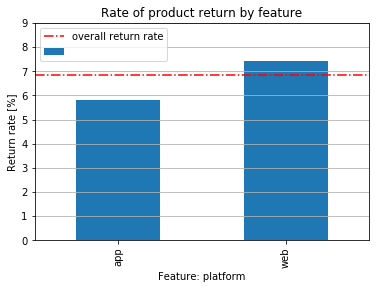

In [592]:
df_train.groupby(feature).returned.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

plt.axhline(y=df_train.returned.mean()*100, color='r', linestyle='-.', label='overall return rate')

plt.title('Rate of product return by feature')
plt.xlabel("Feature: {}".format(feature))
plt.ylabel("Return rate [%]")

plt.ylim(0,9)

plt.grid(axis='y')
plt.legend(loc="upper left", labels=['overall return rate','']);


### Feature: isvip

In [539]:
feature = "isvip"

In [540]:
df_train[feature].value_counts()

Not VIP      270102
VIP           40278
VIP New       33876
VIP@Feb14       609
Name: isvip, dtype: int64

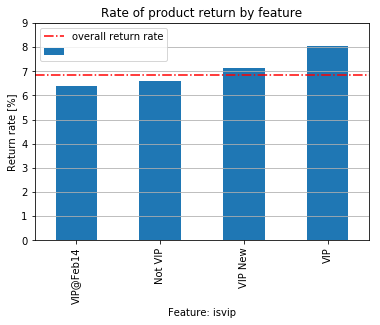

In [541]:
df_train.groupby(feature).returned.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

plt.axhline(y=df_train.returned.mean()*100, color='r', linestyle='-.', label='overall return rate')

plt.title('Rate of product return by feature')
plt.xlabel("Feature: {}".format(feature))
plt.ylabel("Return rate [%]")

plt.ylim(0,9)

plt.grid(axis='y')
plt.legend(loc="upper left", labels=['overall return rate','']);


### Feature: isreseller

In [542]:
feature = "isreseller"

In [543]:
df_train[feature].value_counts()

No     322131
Yes     22734
Name: isreseller, dtype: int64

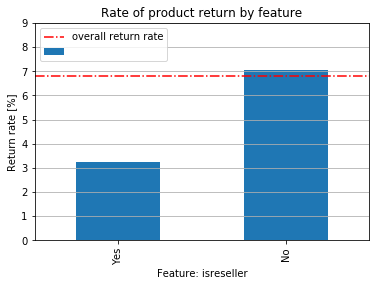

In [544]:
df_train.groupby(feature).returned.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

plt.axhline(y=df_train.returned.mean()*100, color='r', linestyle='-.', label='overall return rate')

plt.title('Rate of product return by feature')
plt.xlabel("Feature: {}".format(feature))
plt.ylabel("Return rate [%]")

plt.ylim(0,9)

plt.grid(axis='y')
plt.legend(loc="upper left", labels=['overall return rate','']);


### Feature: issale

In [558]:
feature = "issale"

In [559]:
df_train[feature].value_counts()

Yes    186827
No     158511
Name: issale, dtype: int64

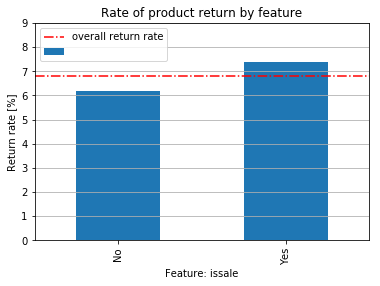

In [560]:
df_train.groupby(feature).returned.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

plt.axhline(y=df_train.returned.mean()*100, color='r', linestyle='-.', label='overall return rate')

plt.title('Rate of product return by feature')
plt.xlabel("Feature: {}".format(feature))
plt.ylabel("Return rate [%]")

plt.ylim(0,9)

plt.grid(axis='y')
plt.legend(loc="upper left", labels=['overall return rate','']);


### Feature: category_1stlevel

In [564]:
feature = "category_1stlevel"

In [568]:
df_train[feature].value_counts()[:13]

Clothing              175807
Shoes                  86590
Accessories            26356
Bags                   23389
Girls Clothing          6559
Boys Clothing           6549
Jewellery               4349
Homeware                2934
Baby Boy Clothing       2461
Baby Girl Clothing      2310
Activewear              1235
Girls Shoes             1159
Teen Boy Clothing       1118
Name: category_1stlevel, dtype: int64

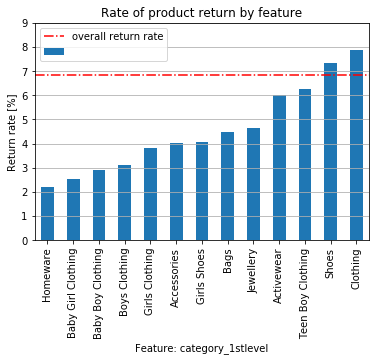

In [573]:
df_train.groupby(feature).filter(lambda x: x.shape[0] > 1000).groupby(feature).returned.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

plt.axhline(y=df_train.returned.mean()*100, color='r', linestyle='-.', label='overall return rate')

plt.title('Rate of product return by feature')
plt.xlabel("Feature: {}".format(feature))
plt.ylabel("Return rate [%]")

plt.ylim(0,9)

plt.grid(axis='y')
plt.legend(loc="upper left", labels=['overall return rate','']);


### Feature: freereturn

In [593]:
feature = "freereturn"

In [594]:
df_train[feature].nunique()

2

In [595]:
df_train[feature].value_counts()

1    329794
0     15544
Name: freereturn, dtype: int64

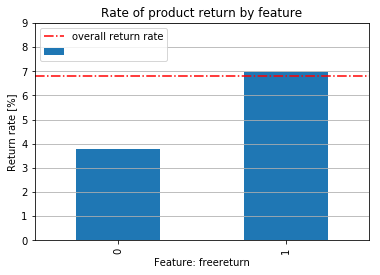

In [596]:
df_train.groupby(feature).returned.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

plt.axhline(y=df_train.returned.mean()*100, color='r', linestyle='-.', label='overall return rate')

plt.title('Rate of product return by feature')
plt.xlabel("Feature: {}".format(feature))
plt.ylabel("Return rate [%]")

plt.ylim(0,9)

plt.grid(axis='y')
plt.legend(loc="upper left", labels=['overall return rate','']);


### Feature: region

In [597]:
feature = "region"

In [598]:
df_train[feature].nunique()

7

In [599]:
df_train[feature].value_counts()

3    139763
4     94436
1     88400
2     21059
5      1171
6       499
7        10
Name: region, dtype: int64

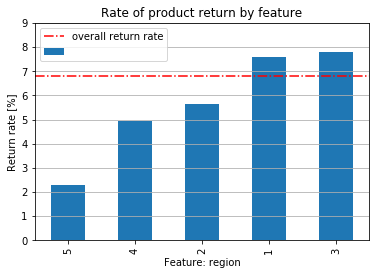

In [601]:
df_train.groupby(feature).filter(lambda x: x.shape[0] > 1000).groupby(feature).returned.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

plt.axhline(y=df_train.returned.mean()*100, color='r', linestyle='-.', label='overall return rate')

plt.title('Rate of product return by feature')
plt.xlabel("Feature: {}".format(feature))
plt.ylabel("Return rate [%]")

plt.ylim(0,9)

plt.grid(axis='y')
plt.legend(loc="upper left", labels=['overall return rate','']);


In [90]:
file_encod = encoding_dict['encoding']

cols_to_use = [col for col in df_aux.columns if col in df_submission.columns]
cols_to_convert = [col for col in df_submission.select_dtypes(include=np.number).columns if col in cols_to_use]
df_submission_dtypes = df_submission.dtypes


df_source1 = df_aux.copy()

# keep only those columns that exist in df_submission
df_source1 = df_source1[cols_to_use]

# Convert numerical columns to numeric dtype
df_source1[cols_to_convert] = df_source1[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Drop observation if having na values in any columns
df_source1 = df_source1.dropna()

# Force types to be exactly the same as in df_submission_dtypes
df_source1 = df_source1.astype(df_submission_dtypes[cols_to_use])

# print(df_source1.dtypes)
# print(df_submission[cols_to_use].dtypes)



tierafterorder     object
orderportalid       int64
size                int64
orderdate_gmt      object
hasusedwishlist    object
dtype: object
tierafterorder     object
orderportalid       int64
size                int64
orderdate_gmt      object
hasusedwishlist    object
dtype: object


# Import API data

In [104]:
API_url = 'https://y29rdnycjd.execute-api.eu-west-1.amazonaws.com/dev/'
request = requests.get(API_url)

In [106]:
request.ok

True

In [107]:
endpoint_url = API_url + 'missingdata/{id}'
endpoint_url

'https://y29rdnycjd.execute-api.eu-west-1.amazonaws.com/dev/missingdata/{id}'

### Performing a sample request

In [165]:
sample_id = df_source1.sample(1).index.values[0]
sample_id = '19ca14e7ea6328a42e0eb13d585e4c22'

In [166]:
request = requests.get(endpoint_url.format(id=sample_id))

In [167]:
request.request.url

'https://y29rdnycjd.execute-api.eu-west-1.amazonaws.com/dev/missingdata/19ca14e7ea6328a42e0eb13d585e4c22'

In [168]:
request.ok

True

In [172]:
request.json()

{'orderportalid': 382388,
 'orderdate_gmt': '2018-01-01 00:15:06.020000+00:00',
 'designer': 4295,
 'style': 4299,
 'shipper': 2,
 'shiptypeid': 2,
 'userid': 257187.0,
 'isvip': 'Not VIP',
 'country': 1,
 'region': 1,
 'ddprate': 5.0083,
 'countrycode': 1,
 'hasusedwishlist': 'Yes',
 'isreseller': 'No',
 'hasitemsonbag': 'No',
 'tierafterorder': None,
 'tierbeforeorder': None,
 'isusingmultipledevices': 'Yes',
 'userfraudstatus': 3,
 'promocode': 1,
 'freereturn': 1,
 'issale': 'Yes',
 'productid': 4450,
 'brand': 337,
 'ddpsubcategory': 'Footwear with outer soles of rubber or plastics',
 'storeid': 5,
 'countryoforigin': 1,
 'size': 12,
 'category_1stlevel': 'Shoes',
 'platform': 'web',
 'returned': None}

In [197]:
# ids_to_request_series = df_aux[df_aux.tierafterorder == 'API'].reset_index().id
# replies_list = []

# for id_to_request in ids_to_request_series:
    
#     request = requests.get(endpoint_url.format(id=id_to_request))
#     if request.ok:
#         replies_list.append(request.json())
#     else:
#         pass
    
# df_train = pd.DataFrame(replies_list)

In [200]:
df_train.returned.nunique()

0

In [193]:
df_aux[df_aux.tierafterorder == 'API'].reset_index().id[0:20]

pandas.core.series.Series

In [189]:
replies_list[0]

{'orderportalid': 382388,
 'orderdate_gmt': '2018-01-01 00:15:06.020000+00:00',
 'designer': 4295,
 'style': 4299,
 'shipper': 2,
 'shiptypeid': 2,
 'userid': 257187.0,
 'isvip': 'Not VIP',
 'country': 1,
 'region': 1,
 'ddprate': 5.0083,
 'countrycode': 1,
 'hasusedwishlist': 'Yes',
 'isreseller': 'No',
 'hasitemsonbag': 'No',
 'tierafterorder': None,
 'tierbeforeorder': None,
 'isusingmultipledevices': 'Yes',
 'userfraudstatus': 3,
 'promocode': 1,
 'freereturn': 1,
 'issale': 'Yes',
 'productid': 4450,
 'brand': 337,
 'ddpsubcategory': 'Footwear with outer soles of rubber or plastics',
 'storeid': 5,
 'countryoforigin': 1,
 'size': 12,
 'category_1stlevel': 'Shoes',
 'platform': 'web',
 'returned': None}

In [188]:
pd.DataFrame(replies_list)

,brand,category_1stlevel,country,countrycode,countryoforigin,ddprate,ddpsubcategory,designer,freereturn,hasitemsonbag,...,returned,shipper,shiptypeid,size,storeid,style,tierafterorder,tierbeforeorder,userfraudstatus,userid
0,337,Shoes,1,1,1,5.0083,Footwear with outer soles of rubber or plastics,4295,1,No,...,None,2,2,12,5,4299,None,None,3,257187.0
1,681,Clothing,1,1,8,0.0000,Skirts,79959,1,No,...,None,1,1,395,764,79978,None,None,3,270119.0
2,9,Bags,3,3,1,0.0000,"Handbags, whether or not with shoulder strap, ...",13129,1,Yes,...,None,2,2,17,174,13136,None,None,3,264764.0
3,92,Clothing,4,4,1,0.0000,"Jerseys, pullovers, cardigans, waistcoats and ...",268,1,Yes,...,None,2,9,35,156,268,VIP,VIP,6,195.0
4,1617,Teen Girl Clothing,1,1,1,5.0083,Dresses,148401,1,No,...,None,4,2,10,163,148434,None,None,3,254415.0
5,50,Homeware,4,4,2,0.0000,Articles of a kind normally carried in the poc...,428,1,No,...,None,1,3,17,39,429,T4,None,3,287.0
6,212,Shoes,1,1,1,5.0083,Other footwear,489,1,No,...,None,2,2,12,32,491,T4,None,3,333.0
7,67,Clothing,12,12,1,33.3833,"T-shirts, singlets and other vests",494,1,No,...,None,2,2,14,11,496,T3,None,3,334.0
8,216,Clothing,39,39,1,0.0000,"Coats: overcoats, raincoat, cape, cloaks and s...",515,1,Yes,...,None,1,3,7,106,517,VIP,VIP,6,342.0
9,141,Shoes,1,1,1,5.0083,Other footwear,150642,1,Yes,...,None,2,2,12,598,150675,T4,T4,3,258716.0


In [175]:
df_aux.index.values[0:10]

array(['cfcd208495d565ef66e7dff9f98764da',
       'c4ca4238a0b923820dcc509a6f75849b',
       'c81e728d9d4c2f636f067f89cc14862c',
       'eccbc87e4b5ce2fe28308fd9f2a7baf3',
       'a87ff679a2f3e71d9181a67b7542122c',
       'e4da3b7fbbce2345d7772b0674a318d5',
       '1679091c5a880faf6fb5e6087eb1b2dc',
       '8f14e45fceea167a5a36dedd4bea2543',
       'c9f0f895fb98ab9159f51fd0297e236d',
       '45c48cce2e2d7fbdea1afc51c7c6ad26'], dtype=object)

In [153]:
df_source1.tierafterorder.value_counts()

T4     212069
T2      75849
T3      70034
VIP     65282
T1      38064
Name: tierafterorder, dtype: int64

In [158]:
df_aux.tierafterorder.value_counts()

T4         212474
T2          75885
T3          70078
VIP         65361
WEBSITE     40000
T1          38079
API         10000
Name: tierafterorder, dtype: int64

In [181]:
type(df_aux[df_aux.tierafterorder == 'API'].index.values)

numpy.ndarray